In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [2]:
!pip install transformers==4.35.0 datasets evaluate

In [3]:
import transformers

In [4]:
print(transformers.__version__)

4.35.0


In [5]:
import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df = pd.read_csv('/content/drive/MyDrive/test/selected_dataset.csv')
df.head()

,condition_label,medical_abstract
0,5,Tissue changes around loose prostheses. A cani...
1,1,Neuropeptide Y and neuron-specific enolase lev...
2,2,"Sexually transmitted diseases of the colon, re..."
3,1,Lipolytic factors associated with murine and h...
4,3,Does carotid restenosis predict an increased r...


In [7]:
df.shape

(8500, 2)

In [8]:

label_mapping = {
   1 : 'neoplasms',
    2:'digestive',
    3: 'nervous',
    4: 'cardiovascular',
    5: 'general',
}

# Replace the values in the 'condition_label' column based on the mapping
df['condition_label'] = df['condition_label'].map(label_mapping)

In [9]:
df = df.rename(columns={'condition_label': 'category'})
df = df.rename(columns={'medical_abstract': 'text'})
df.head(1000)

,category,text
0,general,Tissue changes around loose prostheses. A cani...
1,neoplasms,Neuropeptide Y and neuron-specific enolase lev...
2,digestive,"Sexually transmitted diseases of the colon, re..."
3,neoplasms,Lipolytic factors associated with murine and h...
4,nervous,Does carotid restenosis predict an increased r...
...,...,...
995,cardiovascular,Hemopump support for the failing heart. Under ...
996,nervous,Signs distinguishing spasmus nutans (with and ...
997,cardiovascular,Clinicopathologic studies of children who die ...
998,neoplasms,The interferon system in carcinoma of the cerv...


# Histogram of the count of text

In [10]:
df['count'] = df['text'].apply(lambda x: len(x.split()))

In [11]:
df.head()

,category,text,count
0,general,Tissue changes around loose prostheses. A cani...,156
1,neoplasms,Neuropeptide Y and neuron-specific enolase lev...,187
2,digestive,"Sexually transmitted diseases of the colon, re...",256
3,neoplasms,Lipolytic factors associated with murine and h...,146
4,nervous,Does carotid restenosis predict an increased r...,233


<Figure size 800x800 with 0 Axes>

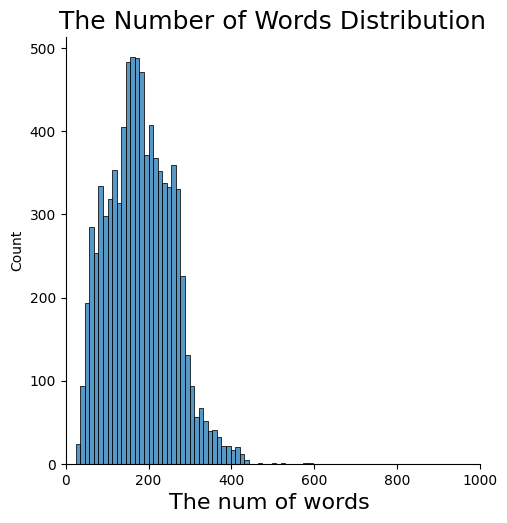

In [12]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 1000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()



# Bar plot for each of the new category

In [13]:
category_count = df['category'].value_counts()

categories = category_count.index

categories

Index(['general', 'neoplasms', 'cardiovascular', 'nervous', 'digestive'], dtype='object')

In [14]:
category_count

general           2841
neoplasms         1882
cardiovascular    1804
nervous           1088
digestive          885
Name: category, dtype: int64

In [15]:
category_count.index

Index(['general', 'neoplasms', 'cardiovascular', 'nervous', 'digestive'], dtype='object')

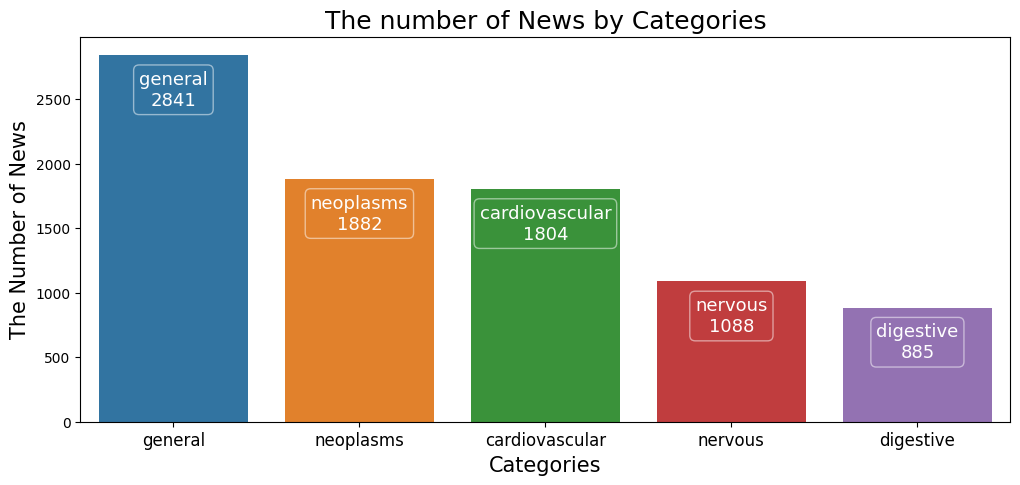

In [16]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [17]:
df['category'].unique()

array(['general', 'neoplasms', 'digestive', 'nervous', 'cardiovascular'],
      dtype=object)

In [18]:
df['encoded_text'] = df['category'].astype('category').cat.codes

df.head(10)

,category,text,count,encoded_text
0,general,Tissue changes around loose prostheses. A cani...,156,2
1,neoplasms,Neuropeptide Y and neuron-specific enolase lev...,187,3
2,digestive,"Sexually transmitted diseases of the colon, re...",256,1
3,neoplasms,Lipolytic factors associated with murine and h...,146,3
4,nervous,Does carotid restenosis predict an increased r...,233,4
5,nervous,The shoulder in multiple epiphyseal dysplasia....,78,4
6,digestive,The management of postoperative chylous ascite...,125,1
7,cardiovascular,Pharmacomechanical thrombolysis and angioplast...,184,0
8,general,Color Doppler diagnosis of mechanical prosthet...,230,2
9,general,Noninvasive diagnosis of right-sided extracard...,184,2


In [19]:
data_texts = df['text'].to_list()

data_labels = df['encoded_text'].to_list()

# Train Test SPlit

In [20]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )



# Model Definition

In [21]:
from transformers import TFAutoModelForSequenceClassification

In [22]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [23]:
train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

# Fine-tuning with the TFTrainer class

In [25]:
from transformers import TFAutoModelForSequenceClassification ,TFTrainer, TFTrainingArguments
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 5 )

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109486085 (417.66 MB)
Trainable params: 109486085 (417.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
import numpy as np

In [28]:
import evaluate
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [29]:
from transformers import TFAutoModelForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import AdamW, get_linear_schedule_with_warmup

# Define your learning rate search space
learning_rates = [1e-4]

for lr in learning_rates:
    training_args = TFTrainingArguments(
        output_dir=f'./results_lr_{lr}',
        num_train_epochs=4,
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=100,
        logging_dir='./logs',
        eval_steps=100,
    )

    with training_args.strategy.scope():
        trainer_model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

    trainer = TFTrainer(
        model=trainer_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate on the validation set
    results = trainer.evaluate()

    print(f"Learning Rate: {lr}, Validation Results: {results}")


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/trainer_tf.py:118: FutureWarning:

The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow



Learning Rate: 0.0001, Validation Results: {'eval_loss': 1.1356603774666227, 'eval_accuracy': 0.596830985915493}


In [ ]:
trainer.predict(val_dataset)

PredictionOutput(predictions=array([[-1.1318024 ,  2.677334  ,  2.3936584 , -1.5122492 , -2.5478175 ],
       [-1.6788449 , -1.8261231 ,  2.385487  ,  2.8208137 , -1.5556809 ],
       [-2.3696907 ,  2.2656612 ,  2.736566  , -0.7898356 , -1.9509946 ],
       ...,
       [-1.3033055 , -1.8915471 , -0.94133574,  2.027941  ,  1.9857765 ],
       [ 1.7335142 , -2.0707073 , -0.5747362 ,  2.1328452 , -1.6601036 ],
       [ 0.88423395, -1.0303278 , -1.080818  ,  2.8185692 , -2.0158284 ]],
      dtype=float32), label_ids=array([1, 3, 1, ..., 3, 2, 3], dtype=int32), metrics={'eval_loss': 1.007666258054359})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.0072184054650992}

# Saving & Loading the model

In [30]:
save_directory = '/content/drive/MyDrive/bert1'

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/bert1/tokenizer_config.json',
 '/content/drive/MyDrive/bert1/special_tokens_map.json',
 '/content/drive/MyDrive/bert1/vocab.txt',
 '/content/drive/MyDrive/bert1/added_tokens.json',
 '/content/drive/MyDrive/bert1/tokenizer.json')

# Loading Pre-Trained Model

In [ ]:
tokenizer_fine_tuned = AutoTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFAutoModelForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /content/drive/MyDrive/Untitled folder were not used when initializing TFBertForSequenceClassification: ['dropout_151']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Untitled folder.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
test_text = test_texts[0]

test_text

'Complement activation is a secondary rather than a causative factor in rabbit pulmonary artery ischemia/reperfusion injury. We have previously demonstrated that reperfusion of a rabbit lung in vivo after 24 h of unilateral pulmonary artery occlusion results in edema, transient leukopenia, and intravascular leukocyte aggregation. We hypothesized that complement was activated by reperfusion and that this in turn contributed to lung injury. In the preliminary phase of the study, we found that ischemia followed by reperfusion resulted in a drop in C3 to 15 +/- 10% (mean +/- SEM) of the prereperfusion value as compared with no change in a group of control animals that had undergone an identical thoracotomy but without pulmonary artery occlusion and reperfusion (p less than 0.05). We then studied three groups of animals to determine if complement depletion with cobra venom factor (CVF) prior to ischemia and reperfusion would prevent the injury. Rabbits treated with CVF but without occlusion

In [ ]:
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

prediction_value

0

# Inferencing with Pytorch

In [ ]:
import torch

from transformers import DistilBertForSequenceClassification

tokenizer_fine_tuned_pt = AutoTokenizer.from_pretrained(save_directory)


model_fine_tuned_pt = TFAutoModelForSequenceClassification.from_pretrained(save_directory)


Some layers from the model checkpoint at /content/drive/MyDrive/Untitled folder were not used when initializing TFBertForSequenceClassification: ['dropout_151']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Untitled folder.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
predict_input_pt = tokenizer_fine_tuned_pt(test_text, truncation = True, padding = True, return_tensors = 'pt' )

ouput_pt = model_fine_tuned_pt(predict_input_pt)

prediction_value_pt = torch.argmax(ouput_pt[0], dim = 1 ).item()

prediction_value_pt

ValueError: ignored